### How to prove we are better than random guessing

We have an interesting situation where we work with bounding boxes, resulting in a more difficult way to prove that we are better than random guessing. We will show multiple ways to prove that we are better than random guessing.

### Download Model

In [1]:
import sys
sys.path.append('..')
from project_name.models.yoloModel import YOLOModel
model = YOLOModel()
model.load_model("../runs/obb/train8/weights/best.pt")

Let us now predict for every model and store the results

In [2]:
import os

data_dir = '../project_name/data/valid/'
images_dir = data_dir + 'images/'
labels_dir = data_dir + 'labels/'

image_paths = os.listdir(images_dir)
i = 0

predictions = []

for image in image_paths:
    label_filename = os.path.splitext(image)[0] + '.txt'
    label_path = os.path.join(labels_dir, label_filename)

    results = model.predict(source= images_dir + image, save=False)

    label = ''

    # check and print corresponding label if it exists
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = f.read()
    else:
        print(f"No label file found for {image}")

    predictions.append((image, results, label))


    


image 1/1 /home/ippe-luning/Documents/uni/AppliedML/Applied-ML-Model/reports/../project_name/data/valid/images/image1_1542_png.rf.62deacf7980320313580d67dee1ed8a6.jpg: 1024x832 (no detections), 34.6ms
Speed: 3.5ms preprocess, 34.6ms inference, 29.2ms postprocess per image at shape (1, 3, 1024, 832)

image 1/1 /home/ippe-luning/Documents/uni/AppliedML/Applied-ML-Model/reports/../project_name/data/valid/images/image2_978_png.rf.b1fa6e4655c393a3d4f408f32f9e721c.jpg: 1024x672 None34.9ms
Speed: 3.6ms preprocess, 34.9ms inference, 84.0ms postprocess per image at shape (1, 3, 1024, 672)

image 1/1 /home/ippe-luning/Documents/uni/AppliedML/Applied-ML-Model/reports/../project_name/data/valid/images/image1_155_png.rf.3b17ee4030dd0461fddfc0f3b5583153.jpg: 992x1024 (no detections), 34.4ms
Speed: 5.9ms preprocess, 34.4ms inference, 0.5ms postprocess per image at shape (1, 3, 992, 1024)

image 1/1 /home/ippe-luning/Documents/uni/AppliedML/Applied-ML-Model/reports/../project_name/data/valid/images/i

First we check if it labels an image if it has a fracture and if it labels when it does not have a fracture

In [3]:
true_labels = []
predicted_labels = []
correct = 0

for image, result, label in predictions:
    has_prediction = any(r.obb.xyxy.numel() > 0 for r in result)
    label_is_empty = len(label.strip()) == 0

    true_label = 0 if label_is_empty else 1
    predicted_label = 1 if has_prediction else 0

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)



Let us now create a confusion matrix

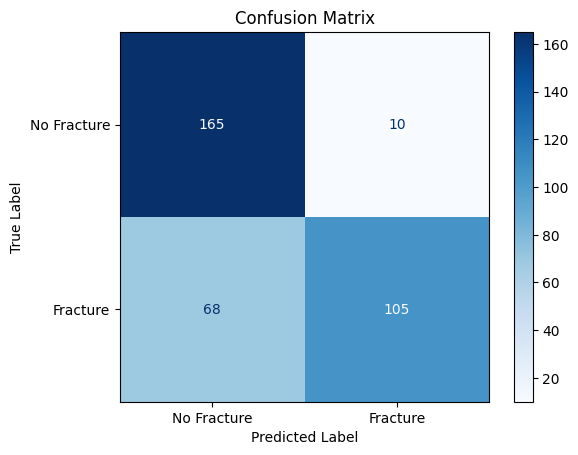

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fracture', 'Fracture'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Testing bounding boxes

Now we will see if the bounding boxes are better than if one would select the entire screen. We use shapify to find the IoU.

In [ ]:
from shapely.geometry import Polygon

def compute_iou(pred_poly, label_poly):

    # convert to Polygon class
    pred_polygon = Polygon(pred_poly)
    label_polygon = Polygon(label_poly)

    if not pred_polygon.is_valid or not label_polygon.is_valid:
        # print("Polygon is not valid")
        return 0.0, 0.0
    
    # Get intersection and union
    intersection_area = pred_polygon.intersection(label_polygon).area
    union_area = pred_polygon.union(label_polygon).area

    if union_area == 0:
        return 0.0
    
    return intersection_area / union_area, label_polygon.area


   


In [10]:
import torch

model_better = 0
random_guess_better = 0

for image, result, label in predictions:
    # if no label is there or the model did not predict, we are unable to calculate IoU
    has_prediction = any(r.obb.xyxy.numel() > 0 for r in result)
    label_is_empty = len(label.strip()) == 0
    if label_is_empty or not has_prediction:
        continue

    # split lines of label
    label_lines = label.splitlines()
    
    iou = 0.0
    for line in label_lines:
        if not line.strip():
            continue  # skip empty labels, sanity check

        label_parts = line.strip().split()
        label_coords = list(map(float, label_parts[1:]))  # skip class label and make it float array
        # print(label_coords)

        # Go from a line to x y tuples
        label_polygon = [(label_coords[i], label_coords[i + 1]) for i in range(0, len(label_coords), 2)]
 
        label_area = 0.0
        for r in result:
            # print(r.obb.xyxyxyxyn)
            pred_coords = r.obb.xyxyxyxyn.cpu().numpy().reshape(-1, 2)
            # print(pred_coords)
            pred_polygon = [tuple(point) for point in pred_coords]

            iou_temp, label_area = compute_iou(pred_polygon, label_polygon)
            iou = iou + iou_temp

            #print(f"IoU: {iou:.4f}")
            # print(f"Label Area: {label_area:.4f}")
    
    # Since coordinates of polygon are in normal coordinates, we only have t o check wether IoU is larger than label area. 
    # Since IoU of a an entire picture with another area has an union area of 1, and a intersection area of the label area.   
    if iou > label_area:
        model_better = model_better + 1
    else:
        random_guess_better = random_guess_better + 1

print(f"Random guess: {random_guess_better}, model: {model_better}, total: {random_guess_better + model_better}")

        

Random guess: 26, model: 67, total: 93
